In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams as pl
pl['figure.figsize'] = 20, 10

In [2]:
# Import raw data
def import_data():
	raw_data_df = pd.read_csv('Power-Networks-LCL2.csv', header=0)
	return raw_data_df

In [3]:
result = import_data()
result.head()

,LCLid,stdorToU,DateTime,KWh,Acorn,Acorn_grouped
0,MAC000002,Std,12-10-2012 00:30,0.0,ACORN-A,Affluent
1,MAC000002,Std,12-10-2012 01:00,0.0,ACORN-A,Affluent
2,MAC000002,Std,12-10-2012 01:30,0.0,ACORN-A,Affluent
3,MAC000002,Std,12-10-2012 02:00,0.0,ACORN-A,Affluent
4,MAC000002,Std,12-10-2012 02:30,0.0,ACORN-A,Affluent


In [4]:
result['date'] = pd.to_datetime(result['DateTime'])
data = result.loc[:, ['KWh']]
data = data.set_index(result.date)
data['KWh'] = pd.to_numeric(data['KWh'], downcast='float',errors='coerce')


In [5]:
data.head()

,KWh
date,
2012-12-10 00:30:00,0.0
2012-12-10 01:00:00,0.0
2012-12-10 01:30:00,0.0
2012-12-10 02:00:00,0.0
2012-12-10 02:30:00,0.0


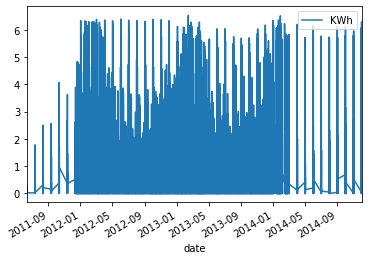

In [6]:
data.plot()

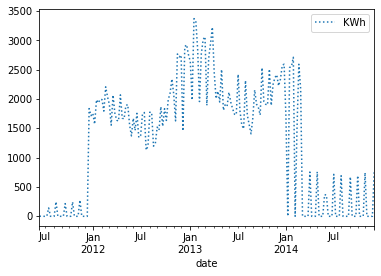

In [7]:
weekly = data.resample('W').sum()
weekly.plot(style=[':','--','-'])

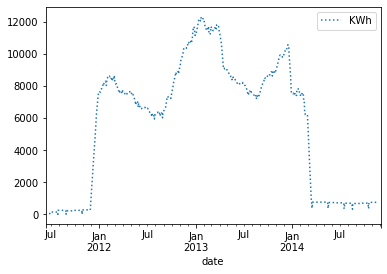

In [8]:
daily = data.resample('D').sum()
daily.rolling(30,center=True).sum().plot(style=[':','--','-'])

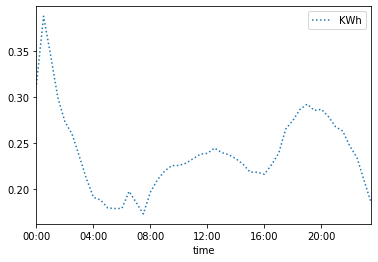

In [9]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60*60*np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':','--','-'])

In [10]:
df = result.loc[:,['date','KWh']]
df['KWh'] = pd.to_numeric(df['KWh'], errors='coerce')
df = df.groupby(['date']).sum().reset_index()
df.head()

,date,KWh
0,2011-06-12 13:00:00,0.105
1,2011-06-12 13:30:00,0.134
2,2011-06-12 14:00:00,0.141
3,2011-06-12 14:30:00,0.130
4,2011-06-12 15:00:00,0.149


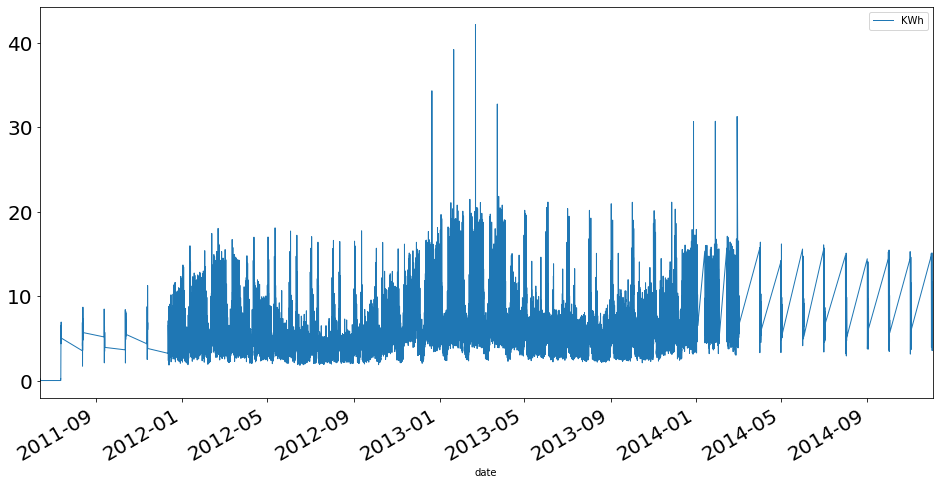

In [11]:
#df
df.plot.line(x='date', y='KWh', figsize= (16,8), linewidth=1, fontsize=20)


In [12]:
mon = df['date']
temp = pd.DatetimeIndex(mon)
month = pd.Series(temp.month)
to_be_plotted = df.drop(['date'], axis=1)
to_be_plotted = to_be_plotted.join(month)

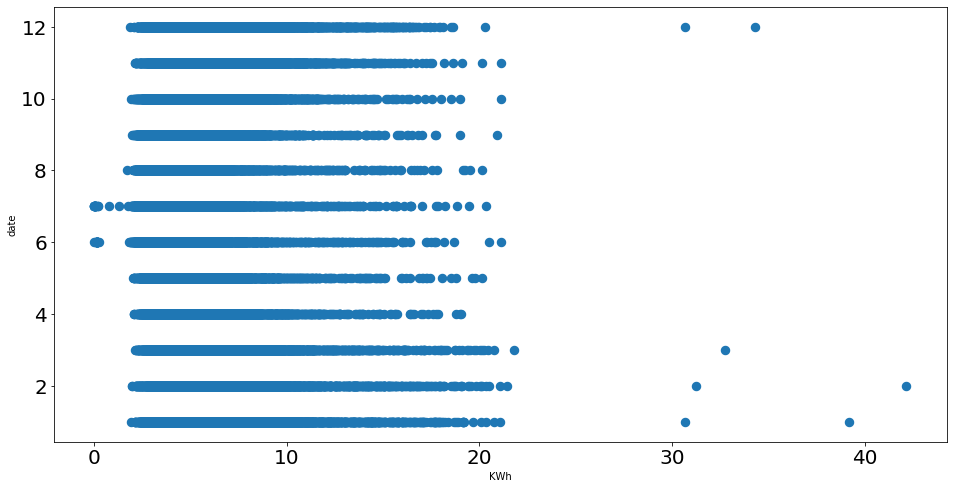

In [13]:
to_be_plotted.plot.scatter(x='KWh', y='date', figsize=(16,8), linewidth=5, fontsize=20)
#plt.show()

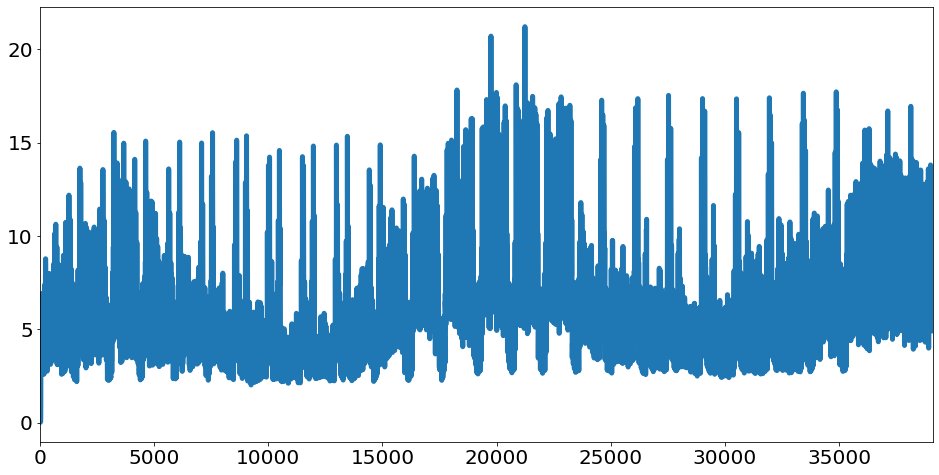

In [14]:
# for trend analysis
df['KWh'].rolling(5).mean().plot(figsize=(16,8), linewidth=5, fontsize= 20)
#plt.show()

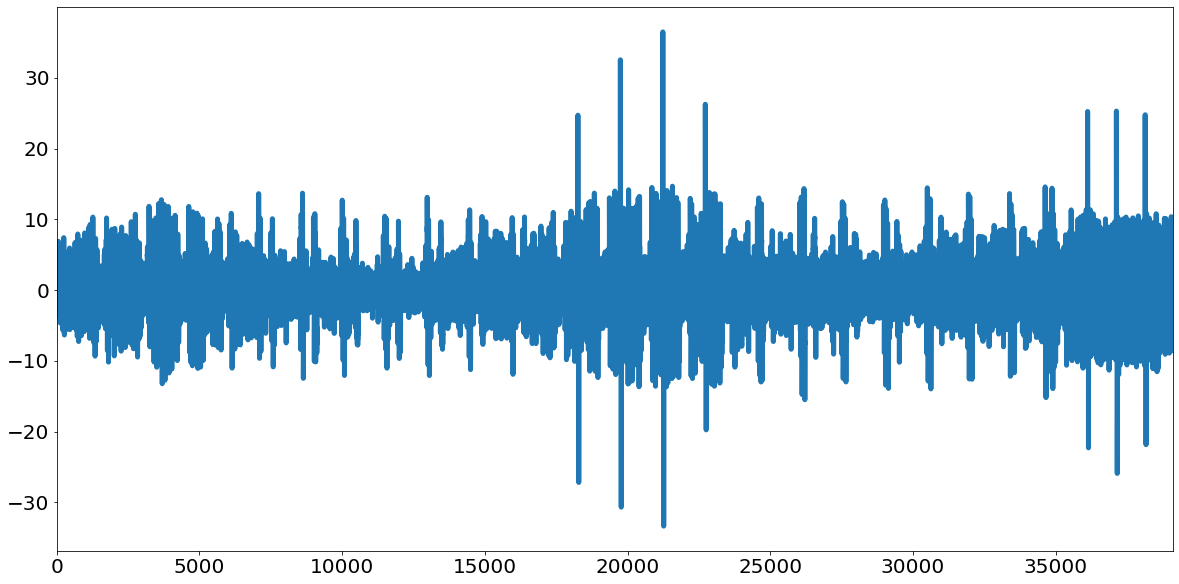

In [15]:
# for seasonal variation
df['KWh'].diff(periods=30).plot(figsize=(20,10), linewidth=5, fontsize=20)

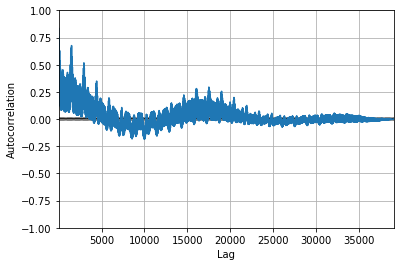

In [16]:
pd.plotting.autocorrelation_plot(df['KWh'])
#plt.show()

In [17]:
df2 = daily
df2.reset_index(inplace=True)
# Prophet requires columns ds (Date) and y (value)
df2 = df2.rename(columns = {'date': 'ds', 'KWh':'y'})
df2.head()


,ds,y
0,2011-06-12,2.947
1,2011-06-13,0.000
2,2011-06-14,0.000
3,2011-06-15,0.000
4,2011-06-16,0.000


In [18]:
import fbprophet
# Make the prophet model and fit on the data
df2_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10)
df2_prophet.fit(df2)

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\k.vamshiKrishna\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [19]:
df2_forecast = df2_prophet.make_future_dataframe(periods=30*2,freq='D')
df2_forecast = df2_prophet.predict(df2_forecast)

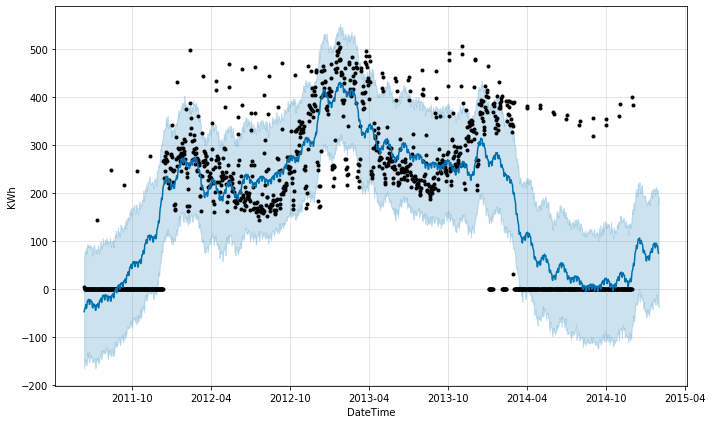

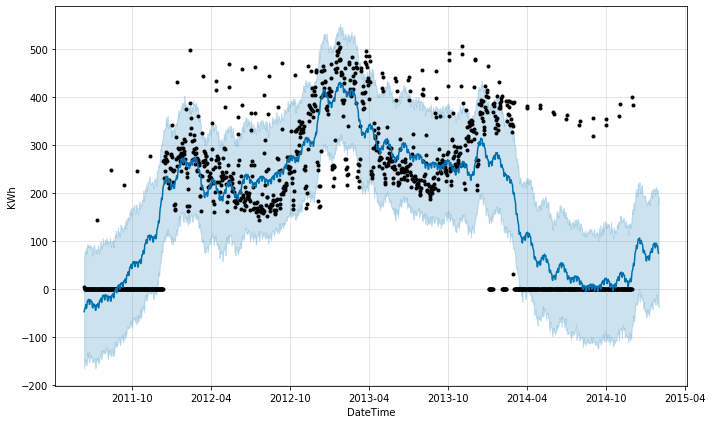

In [20]:
df2_prophet.plot(df2_forecast, xlabel = 'DateTime',ylabel='KWh')

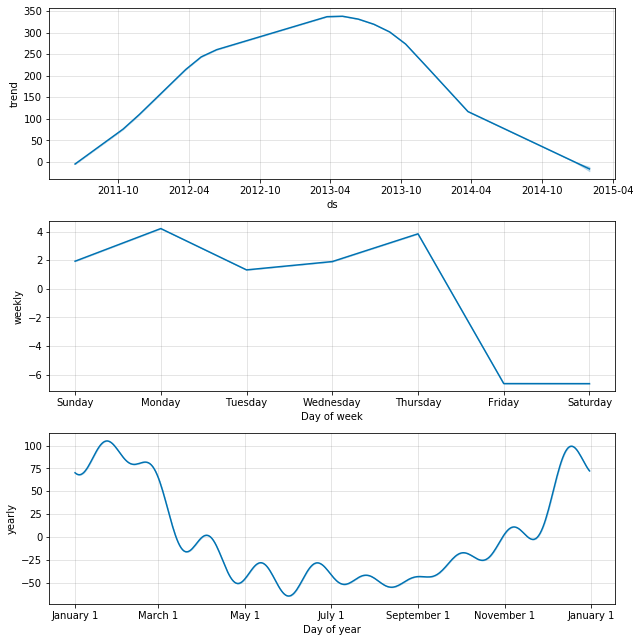

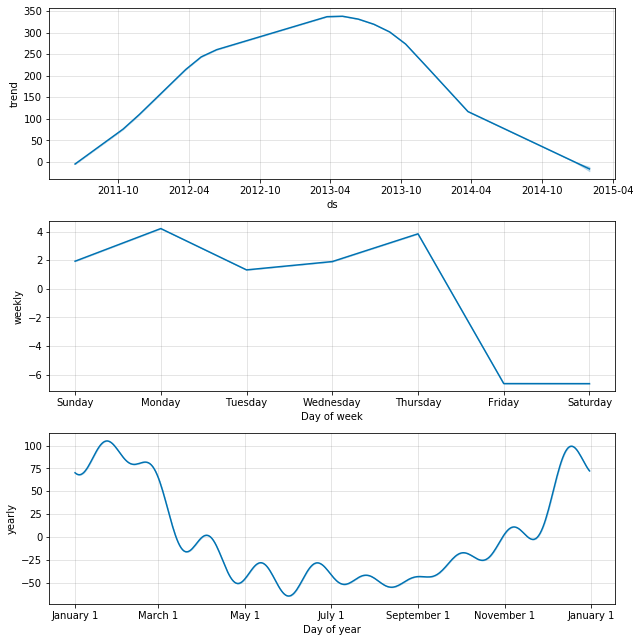

In [21]:
df2_prophet.plot_components(df2_forecast)

In [22]:
mydata = daily.loc[:,['KWh']]
mydata = mydata.set_index(daily.date)
mydata.head()

,KWh
date,
2011-06-12,2.947
2011-06-13,0.000
2011-06-14,0.000
2011-06-15,0.000
2011-06-16,0.000


In [23]:
from sklearn.preprocessing import MinMaxScaler
values = mydata['KWh'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,3))
scaled = scaler.fit_transform(values)

In [24]:
train_size = int(len(scaled)*0.8)
test_size = len(scaled)-train_size
train,test= scaled[0:train_size,:],scaled[train_size:len(scaled),:]
print(len(train),len(test))

1016 254


In [25]:
def create_dataset(dataset,look_back=1):
    dX,dY=[],[]
    for i in range(len(dataset)-look_back): 
        a = dataset[i:(i+look_back),0]
        dX.append(a)
        dY.append(dataset[i+look_back,0])
    print(len(dY))
    return np.array(dX),np.array(dY)
look_back = 1
train_data,trainY = create_dataset(train,look_back)
test_data,testY=create_dataset(test,look_back)


1015
253


In [26]:
for i in range(len(train_data)):
    print(train_data[i],test_data[i])

[0.01727736] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [2.2296653]
[0.] [2.2034473]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.83930355] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [2.2027378]
[0.] [2.2498448]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[1.4561411] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [2.163276]
[0.] [2.1328838]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[1.2682593] [0.]

IndexError: index 253 is out of bounds for axis 0 with size 253

In [27]:
train_data=np.reshape(train_data,(train_data.shape[0],train_data.shape[1],1))
test_data=np.reshape(test_data,(test_data.shape[0],test_data.shape[1],1))

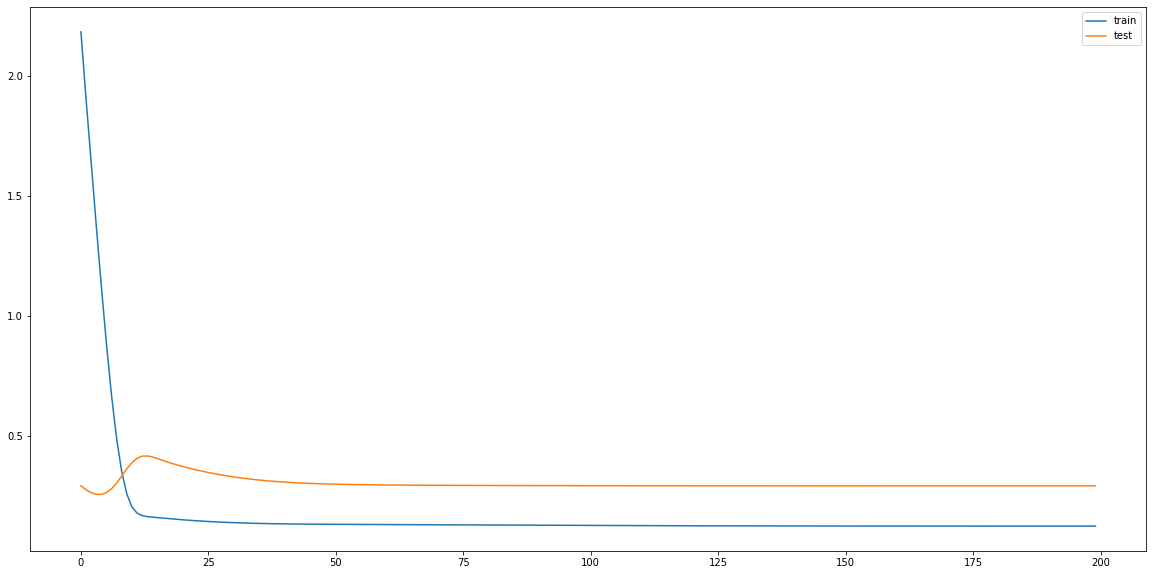

In [35]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
model = Sequential()
model.add(LSTM(100,input_shape=(train_data.shape[1],train_data.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
history = model.fit(train_data, trainY, epochs=200, verbose=0,batch_size=100,validation_data=(test_data,testY),shuffle=False)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()